In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
data_path = './gdrive/MyDrive/Colab Notebooks/GAI_Hw4'

Mounted at /content/gdrive


In [2]:
! pip install torch
! pip install numpy
! pip install matplotlib
! pip install pillow
! pip install scikit-image
! pip install tqdm

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt
import cv2

In [10]:
# Define a simple CNN for DIP
class DIPModel(nn.Module):
    def __init__(self):
        super(DIPModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Define dataset to handle noisy images
class NoisyImageDataset(Dataset):
    def __init__(self, image, noise_levels):
        self.image = image
        self.noise_levels = noise_levels

    def __len__(self):
        return len(self.noise_levels)

    def __getitem__(self, idx):
        noise_level = self.noise_levels[idx]
        noisy_image = self.image + noise_level * torch.randn_like(self.image)
        noisy_image = torch.clamp(noisy_image, 0, 1)
        return noisy_image.squeeze(0), self.image.squeeze(0)

In [11]:
# Utility functions for image processing
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    image = image / 255.0
    return torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0)

def visualize_results(target, reconstructions, psnrs, ssims):
    fig, axes = plt.subplots(2, len(reconstructions) + 1, figsize=(15, 10))
    axes[0, 0].imshow(target.permute(1, 2, 0).cpu().numpy())
    axes[0, 0].set_title('Target Image')
    axes[1, 0].axis('off')

    for i, (recon, p, s) in enumerate(zip(reconstructions, psnrs, ssims)):
        axes[0, i + 1].imshow(recon.permute(1, 2, 0).cpu().numpy())
        axes[0, i + 1].set_title(f'Stage {i+1}\nPSNR: {p:.2f}\nSSIM: {s:.4f}')
        axes[1, i + 1].axis('off')
    plt.show()

# Load and preprocess the target image
target_image = load_image(data_path + '/img_006_SRF_3_LR.png')
noise_levels = [0.3, 0.2, 0.1]  # Start from most noisy to least noisy

# Create the dataset and dataloader
dataset = NoisyImageDataset(target_image, noise_levels)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Initialize the model, loss function, and optimizer
model = DIPModel().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)


<ipython-input-12-95829ed29070>:24: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(target_np, recon_np, multichannel=True)


Noise Level 0.3, Epoch 0/1500, Loss: 0.036237139254808426, PSNR: 8.541388013269293, SSIM: 0.1488611251115799
Noise Level 0.3, Epoch 500/1500, Loss: 0.0004450389533303678, PSNR: 33.695425127676685, SSIM: 0.9562180042266846
Noise Level 0.3, Epoch 1000/1500, Loss: 0.0015467721968889236, PSNR: 28.186755989531843, SSIM: 0.8479912877082825
Noise Level 0.2, Epoch 0/1500, Loss: 0.0008436300558969378, PSNR: 29.821512550536234, SSIM: 0.9098913669586182
Noise Level 0.2, Epoch 500/1500, Loss: 0.0003843227750621736, PSNR: 33.474028401652035, SSIM: 0.9602792859077454
Noise Level 0.2, Epoch 1000/1500, Loss: 0.001585644669830799, PSNR: 28.573809881245626, SSIM: 0.8600926399230957
Noise Level 0.1, Epoch 0/1500, Loss: 0.0004232856153976172, PSNR: 34.4131794372889, SSIM: 0.9617230296134949
Noise Level 0.1, Epoch 500/1500, Loss: 0.0014761686325073242, PSNR: 28.599248680829167, SSIM: 0.8580592274665833
Noise Level 0.1, Epoch 1000/1500, Loss: 0.0014431700110435486, PSNR: 28.505545538796817, SSIM: 0.85549992

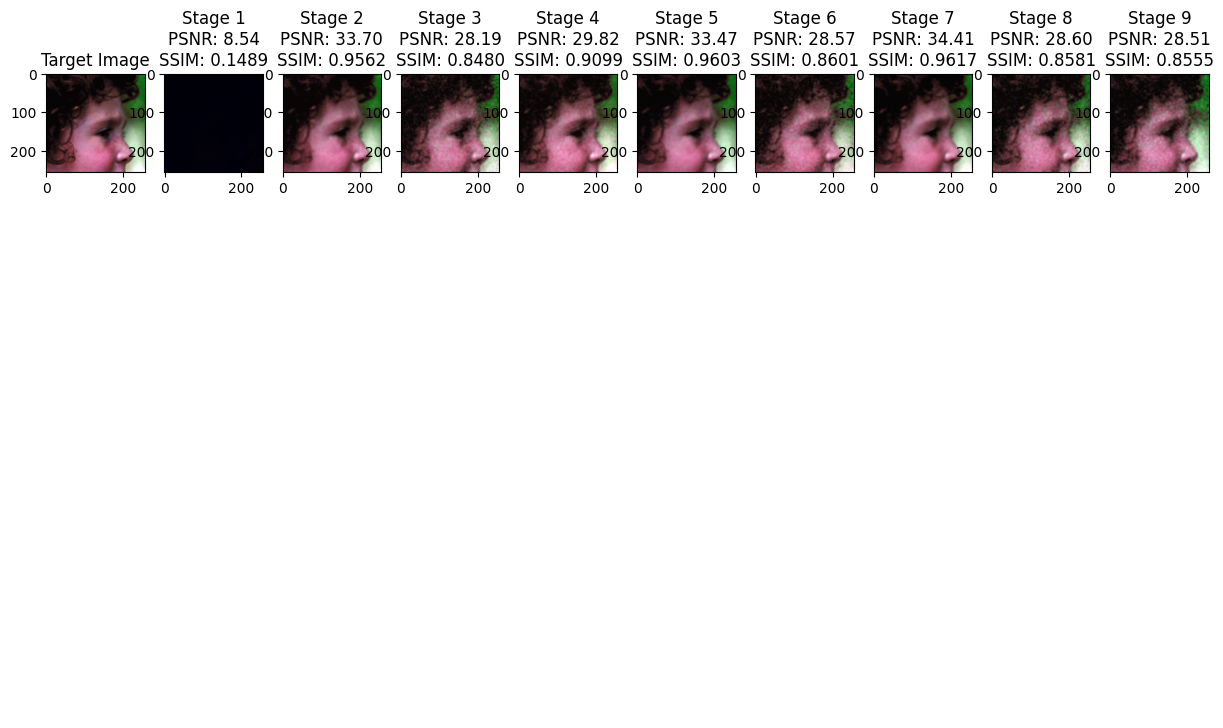

In [12]:
# Training loop
num_epochs = 1500
reconstructions = []
psnrs = []
ssims = []

for noise_level in noise_levels:
    for epoch in range(num_epochs):
        for noisy_image, target in dataloader:
            noisy_image, target = noisy_image.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(noisy_image)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        if epoch % 500 == 0:
            with torch.no_grad():
                recon = model(noisy_image).squeeze(0)
                reconstructions.append(recon.cpu())
                target_np = target.squeeze(0).cpu().numpy().transpose(1, 2, 0)
                recon_np = recon.cpu().numpy().transpose(1, 2, 0)
                psnr_value = psnr(target_np, recon_np)
                ssim_value = ssim(target_np, recon_np, multichannel=True)
                psnrs.append(psnr_value)
                ssims.append(ssim_value)
                print(f'Noise Level {noise_level}, Epoch {epoch}/{num_epochs}, Loss: {loss.item()}, PSNR: {psnr_value}, SSIM: {ssim_value}')

# Visualize the results
visualize_results(target_image.squeeze(0), reconstructions, psnrs, ssims)